In [15]:
import gym
import haiku as hk
import jax
import jax.numpy as jnp
import jax.nn as nn
import jax.random as random
import numpy as np
import optax
import matplotlib.pyplot as plt
import pickle as pkl
from jax import grad
from jax import lax
from jax import jit
from tqdm import tqdm
from collections import namedtuple
%matplotlib inline 

In [16]:
def pol_model(observation):
  mlp = hk.Sequential(
      [
       hk.Linear(20), nn.relu,
       hk.Linear(2)
      ]
  )
  return mlp(observation)

In [17]:

def val_model(observation):
  mlp = hk.Sequential(
      [
       hk.Linear(32), nn.relu,
       hk.Linear(1)
      ]
  )
  return mlp(observation)

In [18]:
def train():
  
  # Define training configurations and problem parameters
  NUM_EPISODE = 2000
  GAMMA = 0.95
  RECORD_INTERVAL = 10
  Record = namedtuple('Record',['obs', 'a', 'r', 'discount'])
  
  # random key generator
  rng = hk.PRNGSequence(0)
  
  # policy and value networks
  pol_net = hk.without_apply_rng(hk.transform(pol_model))
  val_net = hk.without_apply_rng(hk.transform(val_model))

  dummy_obs = jnp.array([0,0,0,0],dtype=jnp.float32)

  pol_params = pol_net.init(rng.next(), dummy_obs)
  val_params = val_net.init(rng.next(), dummy_obs)

  # make optimizers
  pol_opt = optax.adam(1e-4)
  val_opt = optax.adam(2e-4)

  pol_opt_state = pol_opt.init(pol_params)
  val_opt_state = val_opt.init(val_params)

  @jit
  def act(params, obs, rand):
    logits = pol_net.apply(params, obs)
    return random.categorical(rand, logits)
  
  
  # policy related functions
  @jit
  def pol_obj(params, obs, action, tde, discount):
    logits = pol_net.apply(params, obs)
    return -discount*tde*nn.log_softmax(logits)[action]
  
  pol_gradient = jit(grad(pol_obj))
  
  @jit
  def update_pol(params, opt_state, delta): 
    updates, new_opt_state = pol_opt.update(delta, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state
  
  
  # value function related functions
  @jit
  def val_obj(params, obs, target):
    v_t = val_net.apply(params, obs)
    tde = target - v_t
    return (tde**2)[0], tde
  
  val_gradient = jit(grad(val_obj, has_aux=True))
  
  @jit
  def update_val_fn(params, opt_state, delta):
    updates, new_opt_state = val_opt.update(delta, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

  
  # environment
  env = gym.make('CartPole-v0')
  env.seed(1)
  
  # record containers
  episode_lengths = []
  avg_tde = []

  for eps in tqdm(range(NUM_EPISODE)):
    
    # initialization for each episode
    o_t = jnp.array(env.reset(), dtype=jnp.float32)
    done = False
    I = 1.0
    cumulative_tde = 0
    num_step = 0
    trajectory = []
    
    # interact with the environment
    while not done:
      action = act(pol_params, o_t, rng.next())

      num_step += 1

      o_tp1, reward, done, _ = env.step(action.item())
      o_tp1 = jnp.array(o_tp1, dtype=jnp.float32)
      
      trajectory.append(Record(o_t, action, reward, I))
      
      I = GAMMA*I
      o_t = o_tp1
    
    # training the policy net and value net
    trajectory.reverse()
    ret = 0.0
    for record in trajectory:
      ret = GAMMA*ret + record.r
      val_delta, tde = val_gradient(val_params, record.obs, ret)
      cumulative_tde += abs(tde.item())
      
      pol_delta = pol_gradient(pol_params, record.obs, record.a, tde.item(), record.discount)
      
      val_params, val_opt_state = update_val_fn(val_params, val_opt_state, val_delta)
      pol_params, pol_opt_state = update_pol(pol_params, pol_opt_state, pol_delta)
    
    
    # recording
    if eps % RECORD_INTERVAL == 0:
      episode_lengths.append(num_step)
      avg_tde.append(cumulative_tde/num_step)
    
  # saving model parameters
  with open('pol_param.pickle','wb') as fp:
    pkl.dump(pol_params, fp)

  with open('val_param.pickle','wb') as fp:
    pkl.dump(val_params, fp)
  
  return episode_lengths, avg_tde
 

  

In [19]:
def plot_figure(episode_lengths, avg_tde):
  plt.figure()
  plt.plot(episode_lengths,'b')
  plt.xlabel('episode/interval')
  plt.ylabel('length')
  plt.grid()
  
  plt.figure()
  plt.plot(avg_tde,'r')
  plt.xlabel('episode/interval')
  plt.ylabel('TD-error')
  plt.grid()

In [20]:
def test(episodes, render=False):
  
  GAMMA = 0.95
  
  # load parameters
  with open('pol_param.pickle','rb') as fp:
    pol_params = pkl.load(fp)
  with open('val_param.pickle','rb') as fp:
    val_params = pkl.load(fp)
  
  # create policy and value net
  pol_net = hk.without_apply_rng(hk.transform(pol_model))
  val_net = hk.without_apply_rng(hk.transform(val_model))
  
  rng = hk.PRNGSequence(0)
  
  @jit
  def act(obs, rng):
    logits = pol_net.apply(pol_params, obs)
    return random.categorical(rng, logits=logits)
  
  @jit
  def pred(obs):
    return val_net.apply(val_params, obs)
  
  # make environment
  env = gym.make('CartPole-v0')
  env.seed(0)
  
  eps_lengths = []
  avg_tdes = []
  
  for eps in range(episodes):
    
    # initialization
    o_t = jnp.array(env.reset(), dtype=jnp.float32)
    done = False
    num_steps = 0
    total_tde = 0
    
    while not done:
      action = act(o_t, rng.next())
      
      o_tp1, reward, done, _ = env.step(action.item())
      o_tp1 = jnp.array(o_tp1, dtype=jnp.float32)
      num_steps += 1
      
      if render:
        env.render()
    
      tde = reward + GAMMA*pred(o_tp1) - pred(o_t)
      total_tde += abs(tde.item())
      
      o_t = o_tp1
      
    eps_lengths.append(num_steps)
    avg_tdes.append(total_tde/num_steps)
  
  env.close()
  return eps_lengths, avg_tdes

In [21]:
def main():
  eps_len, avg_tde = train()
  plot_figure(eps_len, avg_tde)
  eps_len, avg_tde = test(100)
  plot_figure(eps_len, avg_tde)

100%|███████████████████████████████████████| 2000/2000 [01:09<00:00, 28.64it/s]


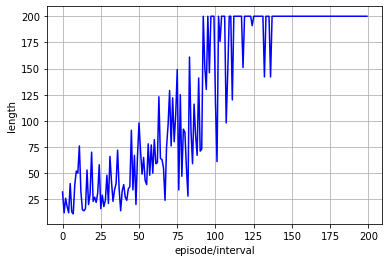

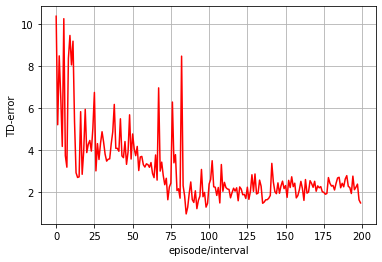

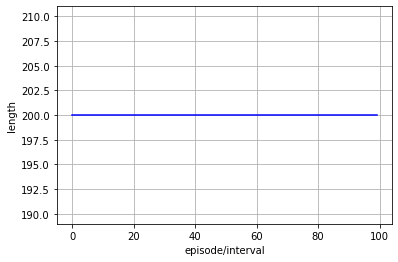

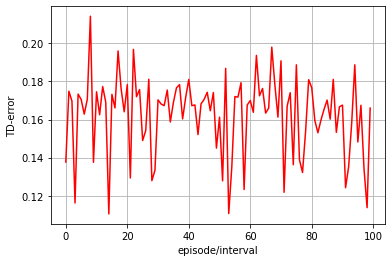

In [22]:
main()